<a href="https://colab.research.google.com/github/DnrMartins/Projetos-AWS/blob/main/Exercicio_M38_Computa%C3%A7%C3%A3o_em_Nuvem_II_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/media/logo/newebac_logo_black_half.png" alt="ebac-logo">

---

# **Módulo** | Computação em Nuvem II
Caderno de **Exercícios**<br>
Professor [André Perez](https://www.linkedin.com/in/andremarcosperez/)

---

# **Tópicos**

<ol type="1">
  <li>AWS Lambda;</li>
  <li>AWS Step Functions;</li>
  <li>AWS EventBridge.</li>
</ol>

---

# **Exercícios**

## 1\. AWS Lambda

Replique as atividades do item 1.3 em sua conta.

# **Bronze**

In [ ]:
import json
import logging
from datetime import datetime

import boto3
import urllib3
from botocore.exceptions import ClientError


def lambda_handler(event, context) -> bool:

  # -- setup

  URL = 'https://api.bcb.gov.br/dados/serie/bcdata.sgs.11/dados?formato=json&dataInicial=01/11/2024&dataFinal=07/11/2024'
  BRONZE_BUCKET = 'modulo38-ebac-denner-bronze'

  client = boto3.client('s3')

  date = datetime.now().strftime('%Y-%m-%d')
  filename_json = f'stock-exchange-{date}.json'

  # -- extract

  try:
    http = urllib3.PoolManager()
    response = http.request(url=URL, method='get')
  except Exception as exc:
    raise exc
  else:
    data = json.loads(response.data.decode())
    logging.info(msg=data)

  # -- transform

  ...

  # -- load

  try:
      with open(f'/tmp/{filename_json}', mode='w', encoding='utf8') as fp:
          json.dump(data, fp)
      client.upload_file(Filename=f'/tmp/{filename_json}', Bucket=BRONZE_BUCKET, Key=filename_json)
  except ClientError as exc:
      raise exc

  return json.dumps(dict(status=True))

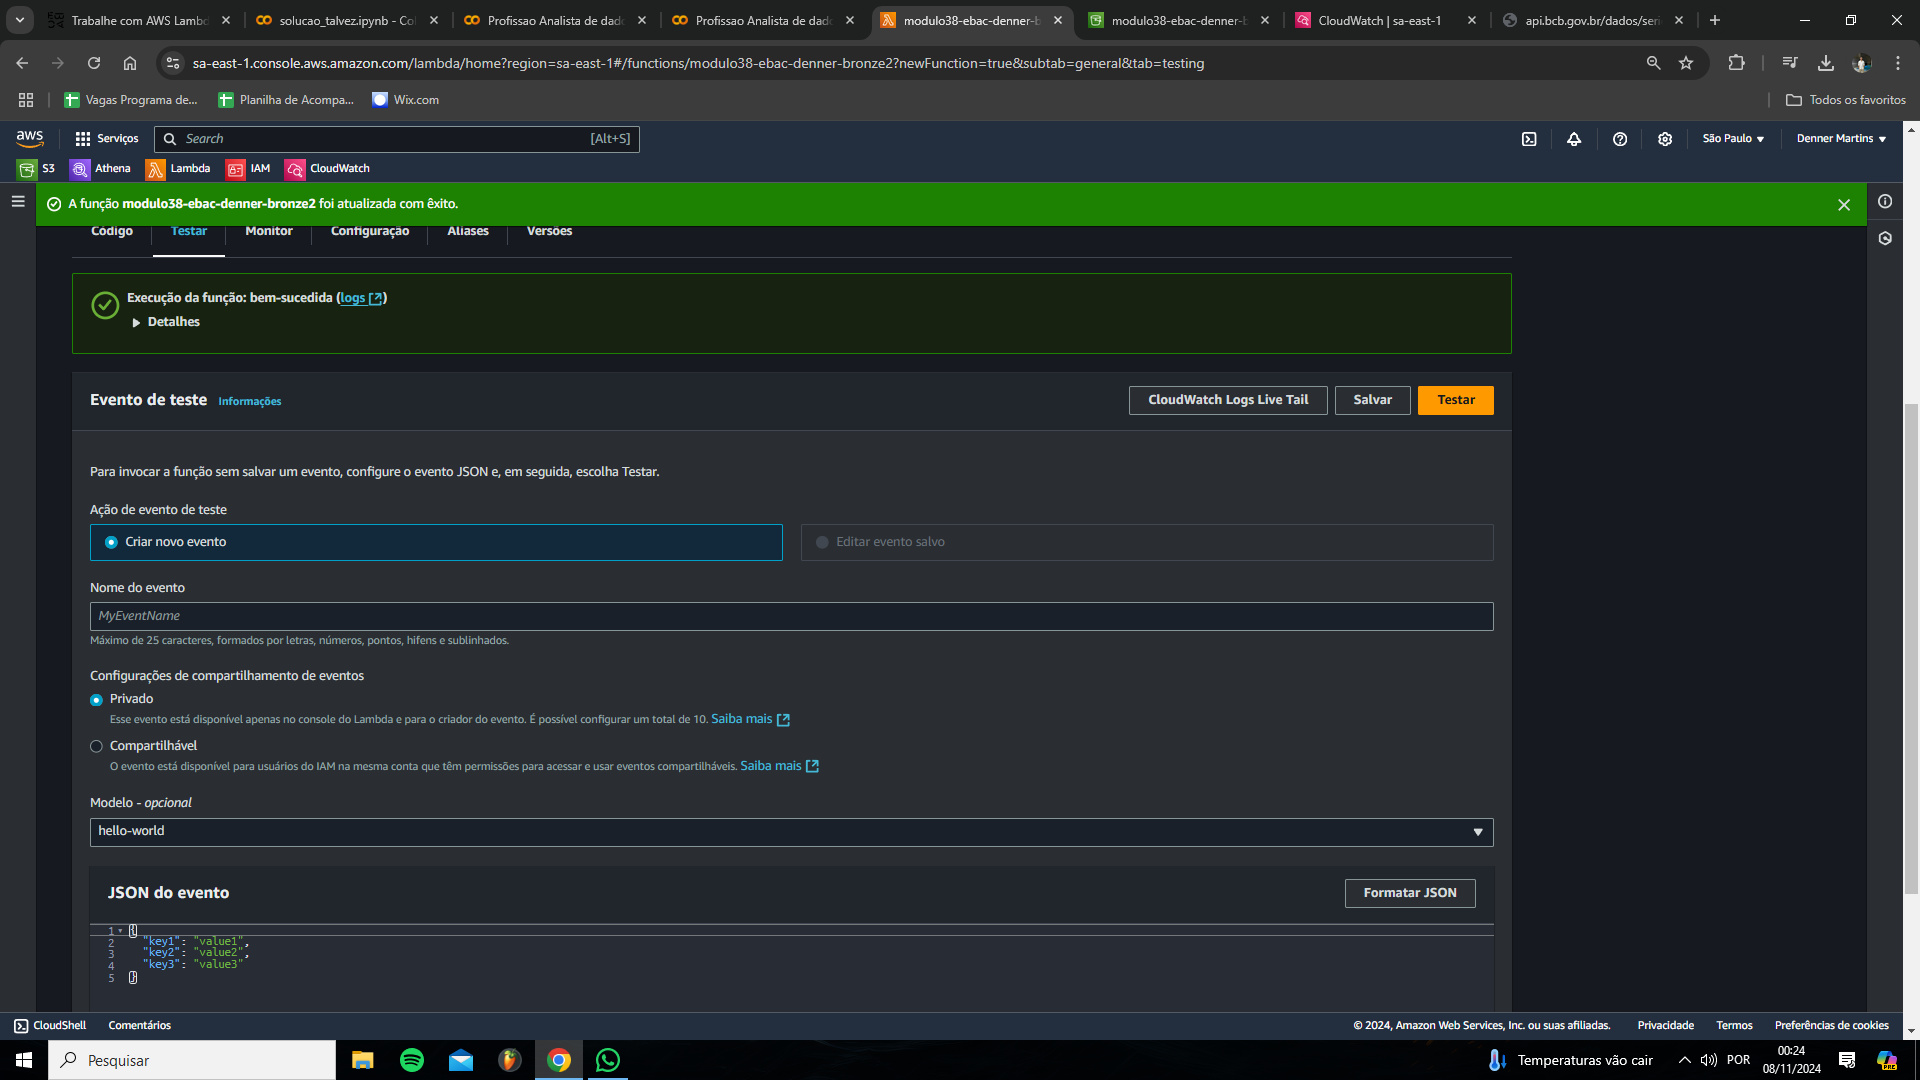

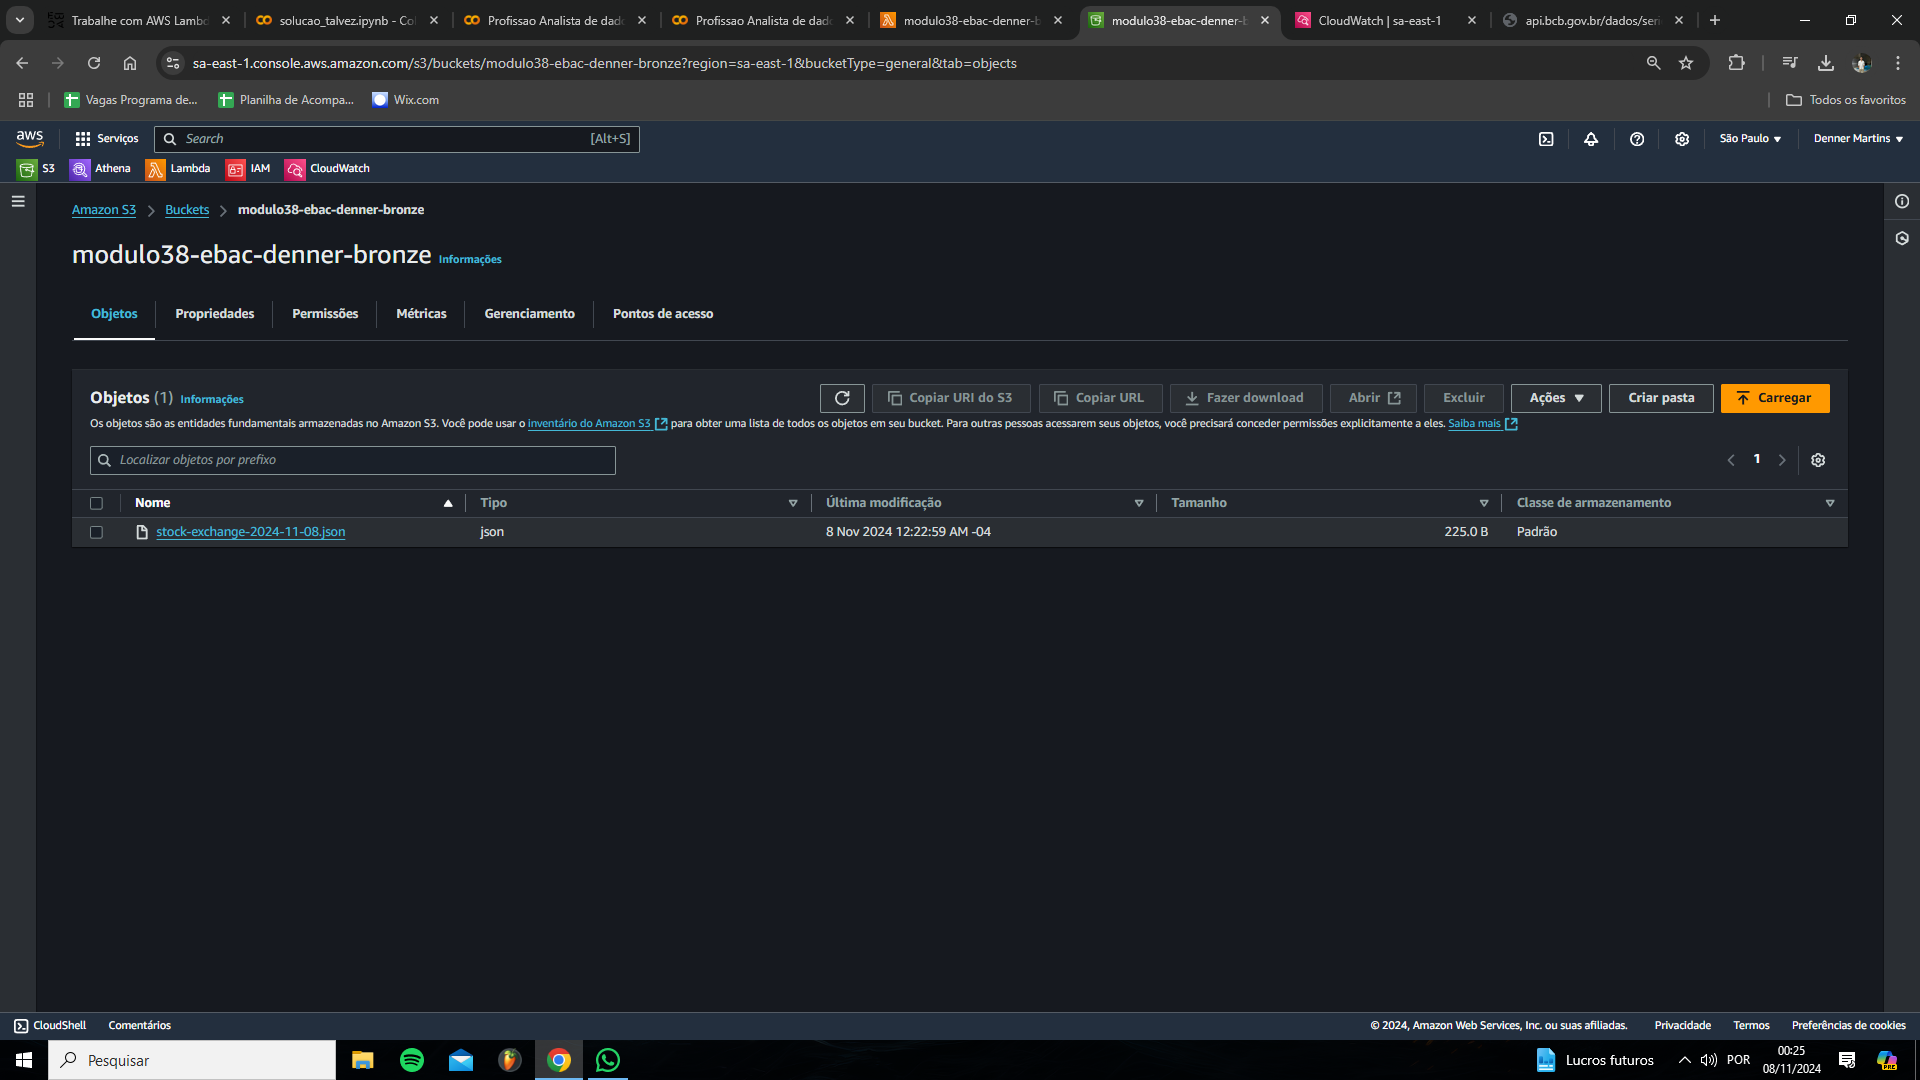

# **Silver**

In [ ]:
import json
from datetime import datetime

import boto3
from botocore.exceptions import ClientError


def lambda_handler(event, context) -> bool:
    # -- setup
    BRONZE_BUCKET = 'modulo38-ebac-denner-bronze'
    SILVER_BUCKET = 'modulo38-ebac-denner-silver'

    client = boto3.client('s3')

    date = datetime.now().strftime('%Y-%m-%d')
    filename_csv = f'stock-exchange-{date}.csv'
    filename_json = f'stock-exchange-{date}.json'

    # -- extract
    client.download_file(BRONZE_BUCKET, filename_json, f'/tmp/{filename_json}')

    with open(f"/tmp/{filename_json}", mode='r', encoding='utf8') as fp:
        data = json.load(fp)

    # -- transform
    transformed_data = []

    for record in data:
        transformed_record = {
            'taxa': record['valor'].replace(',', '.'),
            'dataTaxa': datetime.strptime(record['data'], '%d/%m/%Y').strftime('%Y-%m-%d'),
        }
        transformed_data.append(transformed_record)

    # -- load
    try:
        with open(f'/tmp/{filename_csv}', mode='w', encoding='utf8') as fp:
            fp.write('taxa,dataTaxa\n')
            for record in transformed_data:
                fp.write(f"{record['taxa']},{record['dataTaxa']}\n")
        client.upload_file(Filename=f'/tmp/{filename_csv}', Bucket=SILVER_BUCKET, Key=f'data_referencia={date}/{filename_csv}')
    except ClientError as exc:
        raise exc

    return json.dumps(dict(status=True))

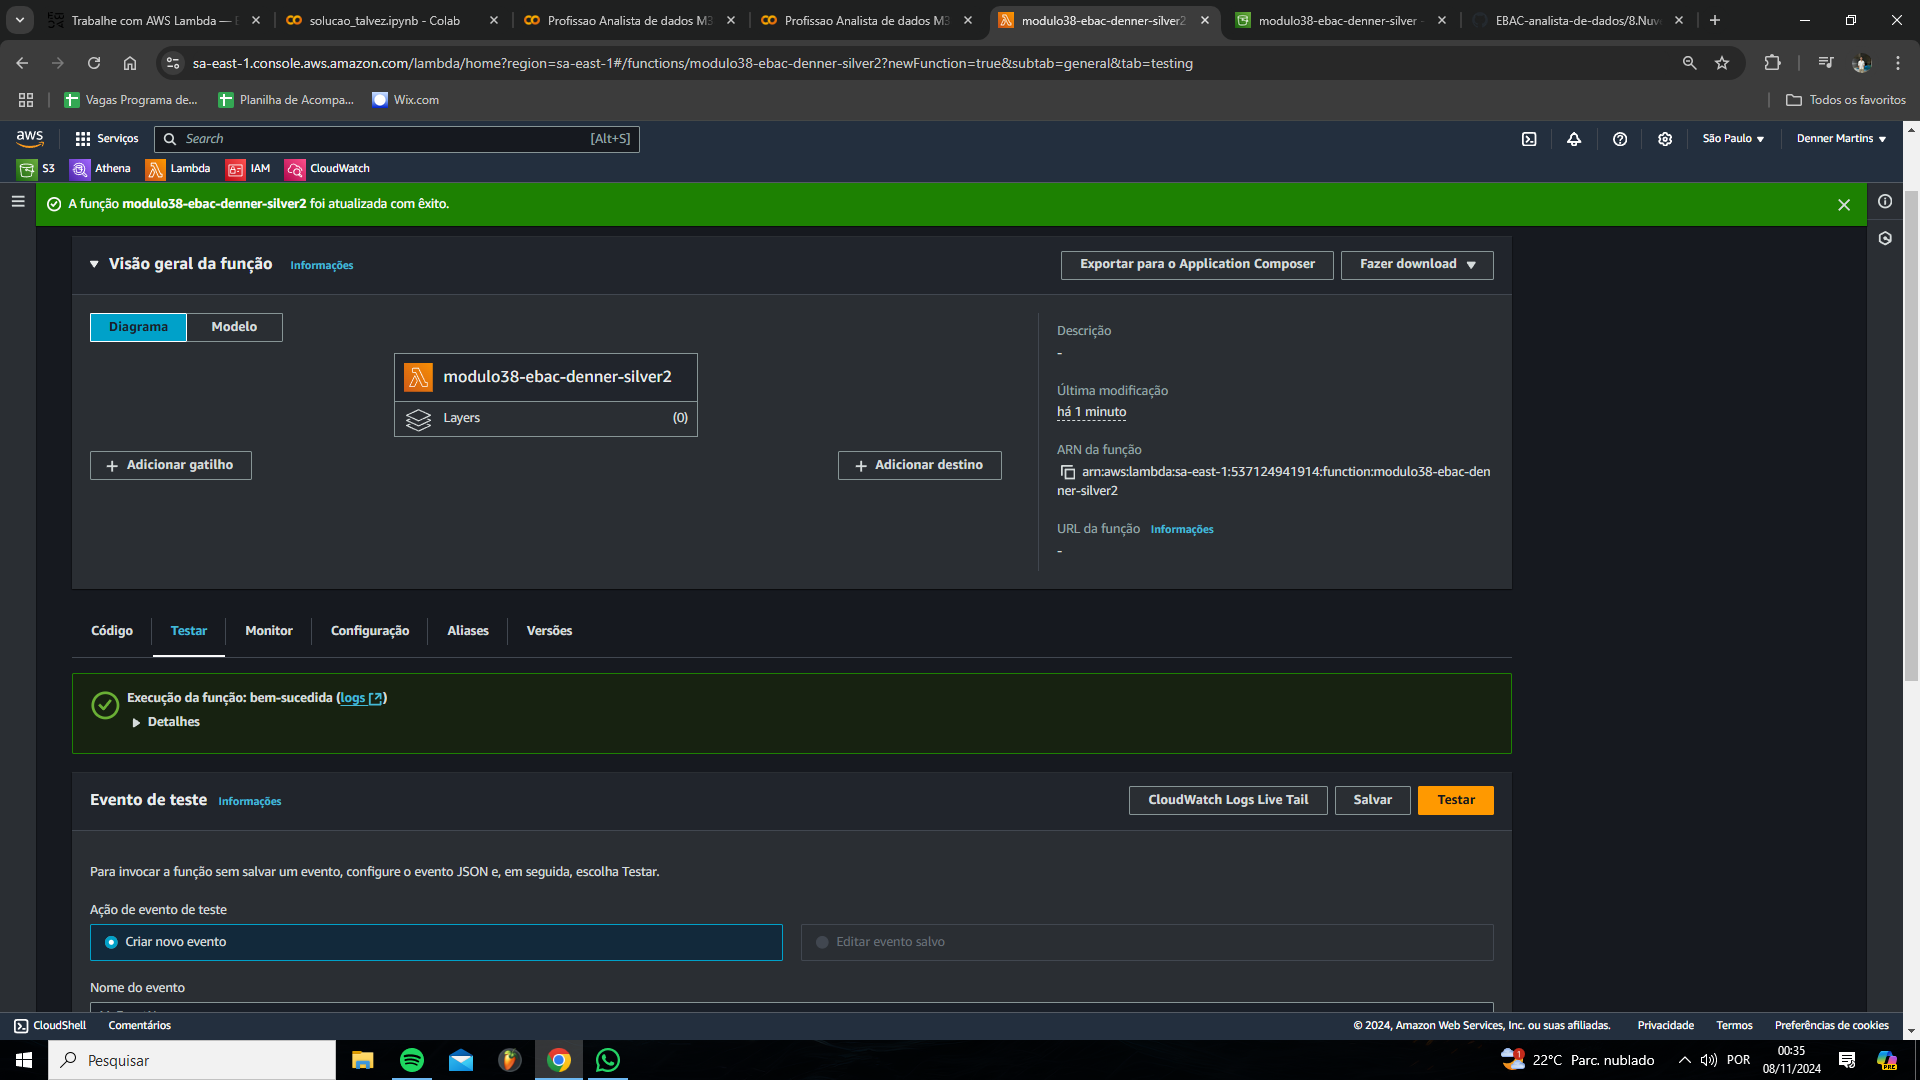

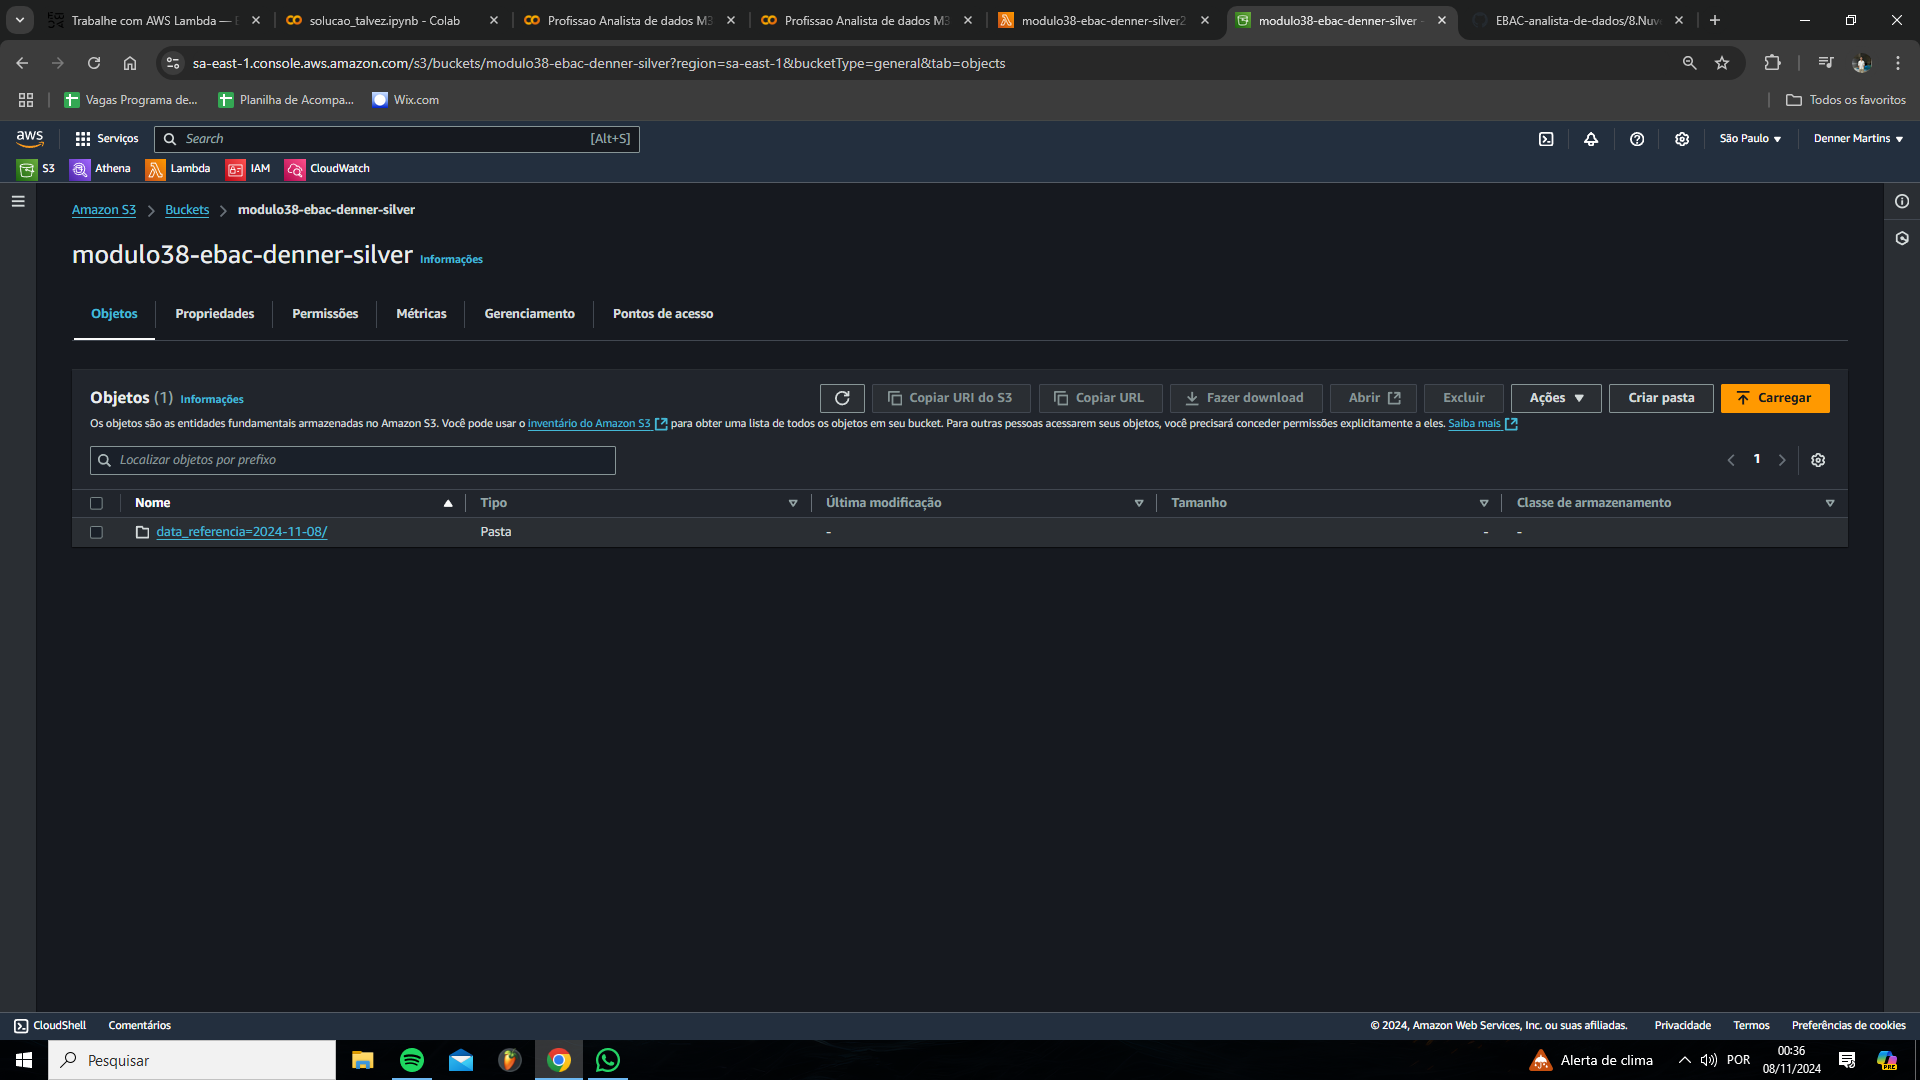

# **Tabela**

In [ ]:
import json
from datetime import datetime

import boto3
from botocore.exceptions import ClientError


def lambda_handler(event, context) -> bool:

  # -- setup

  SILVER_BUCKET = 'modulo38-ebac-denner-silver'

  query = f"""
  CREATE EXTERNAL TABLE IF NOT EXISTS cdi (
    taxa double,
    dataTaxa string
  )
  PARTITIONED BY (
    data_referencia string
  )
  ROW FORMAT SERDE 'org.apache.hadoop.hive.serde2.OpenCSVSerde'
  WITH SERDEPROPERTIES ('separatorChar'=',')
  LOCATION 's3://{SILVER_BUCKET}/'
  """

  client = boto3.client('athena')

  # -- create

  try:
    client.start_query_execution(
      QueryString=query,
      ResultConfiguration={'OutputLocation': 's3://bucket-denner-query-results/'}
    )
  except ClientError as exc:
    raise exc

  # -- update

  try:
    client.start_query_execution(
      QueryString='MSCK REPAIR TABLE cdi',
      ResultConfiguration={'OutputLocation': 's3://bucket-denner-query-results/'}
    )
  except ClientError as exc:
    raise exc

  return json.dumps(dict(status=True))

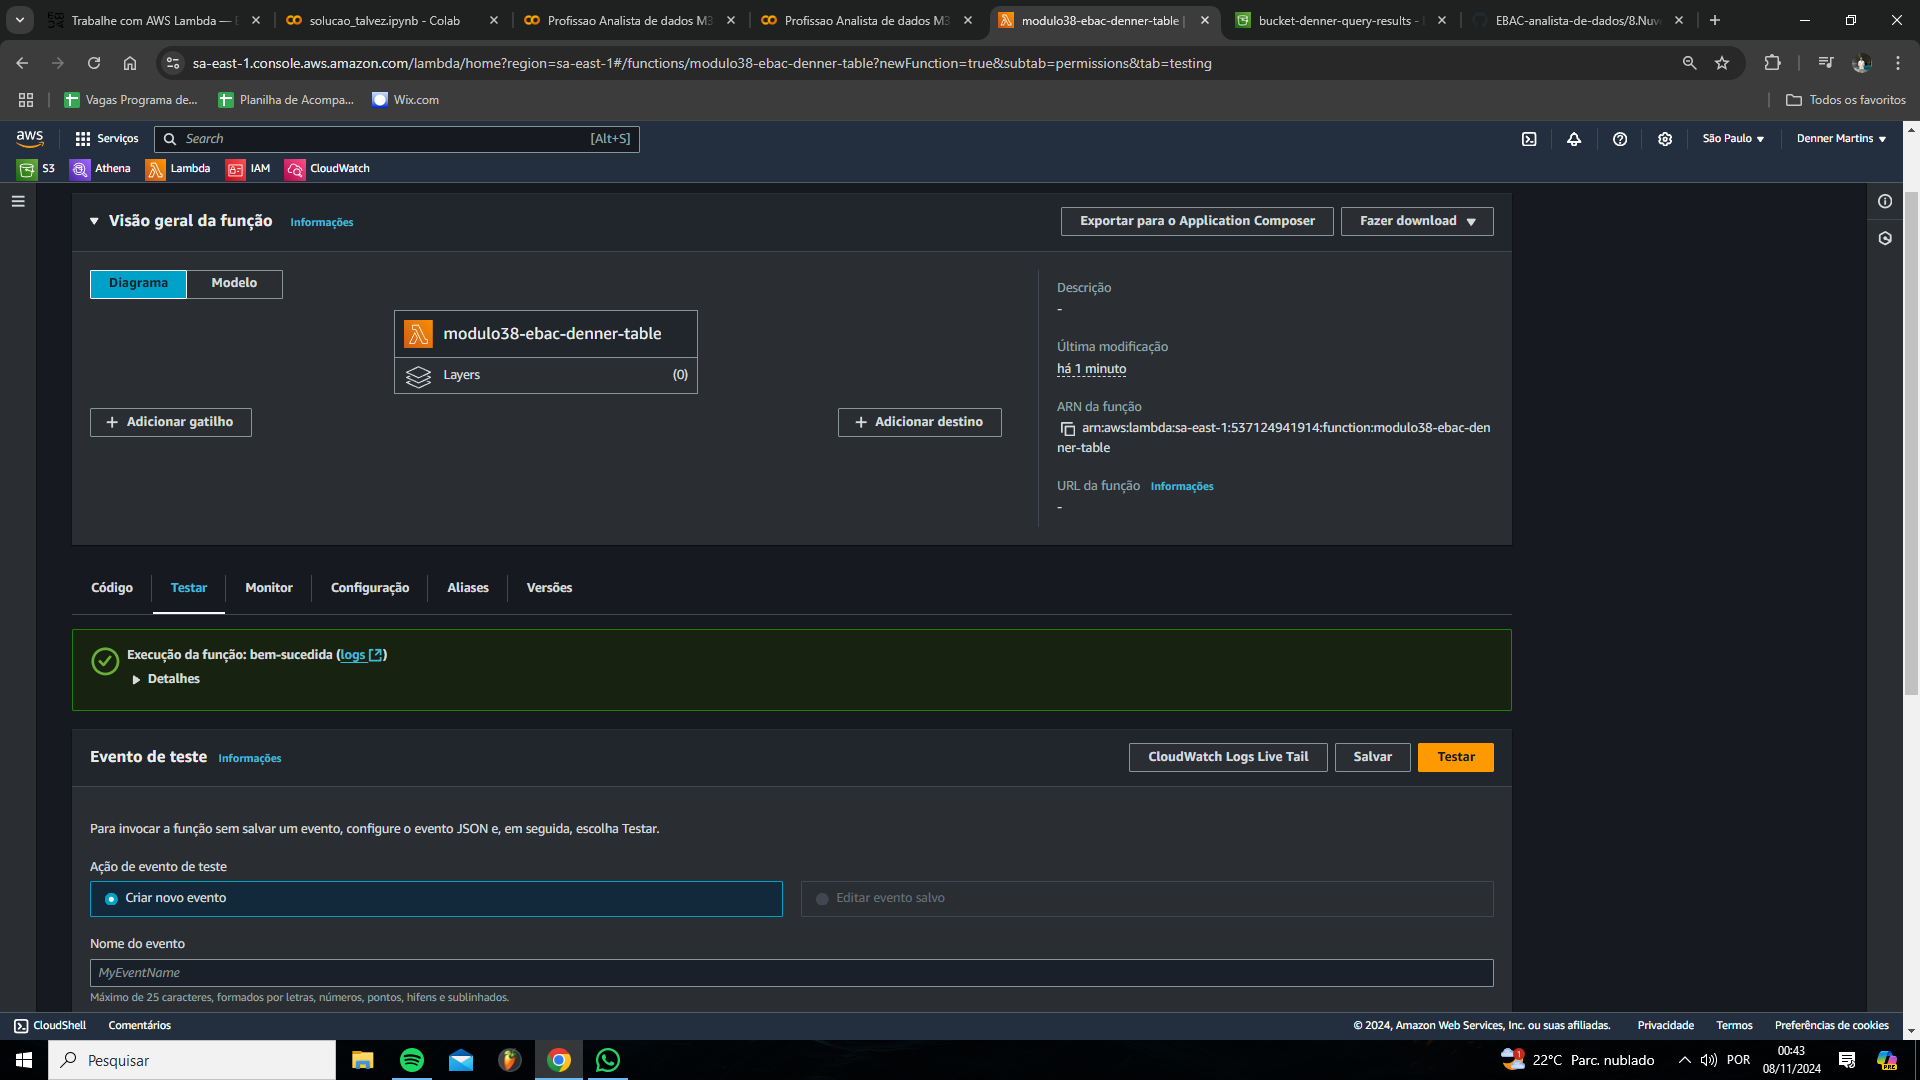

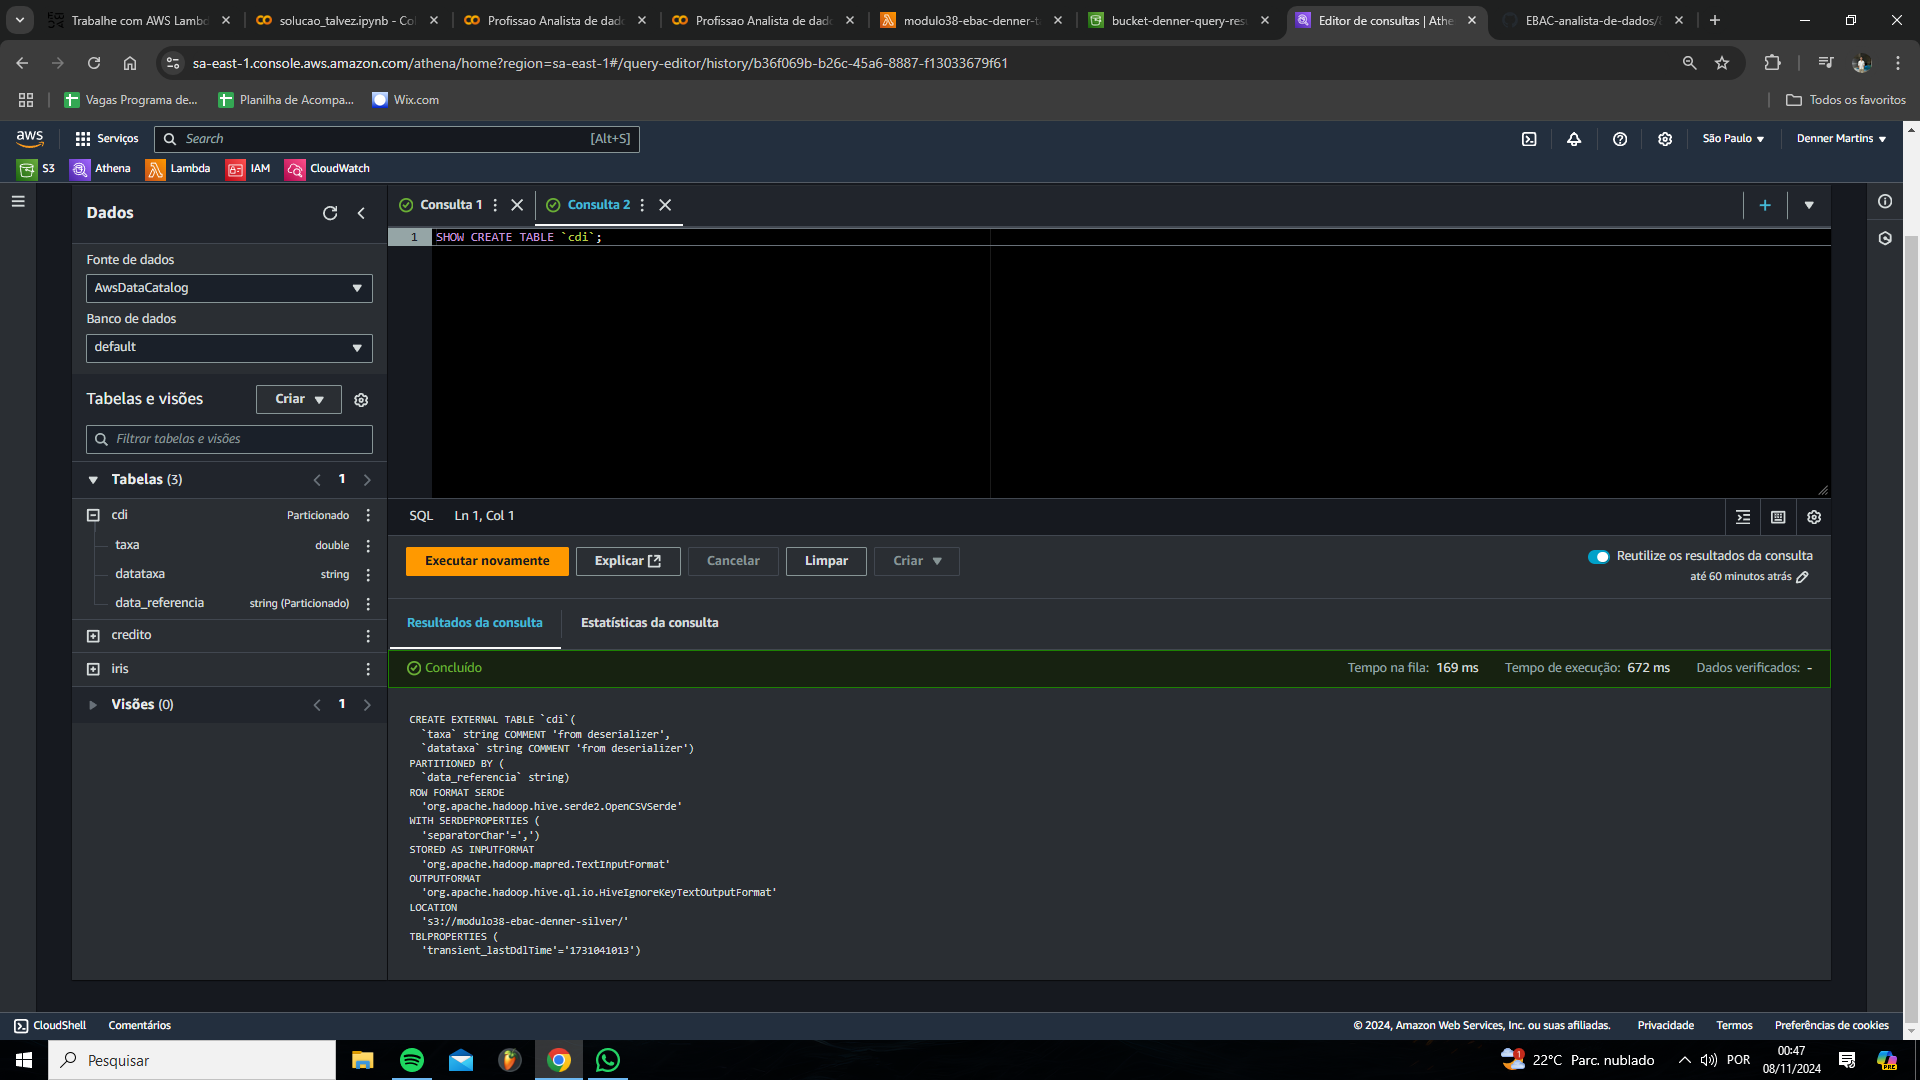

## 2\. AWS Step Functions

Replique as atividades do item 2.3 em sua conta.


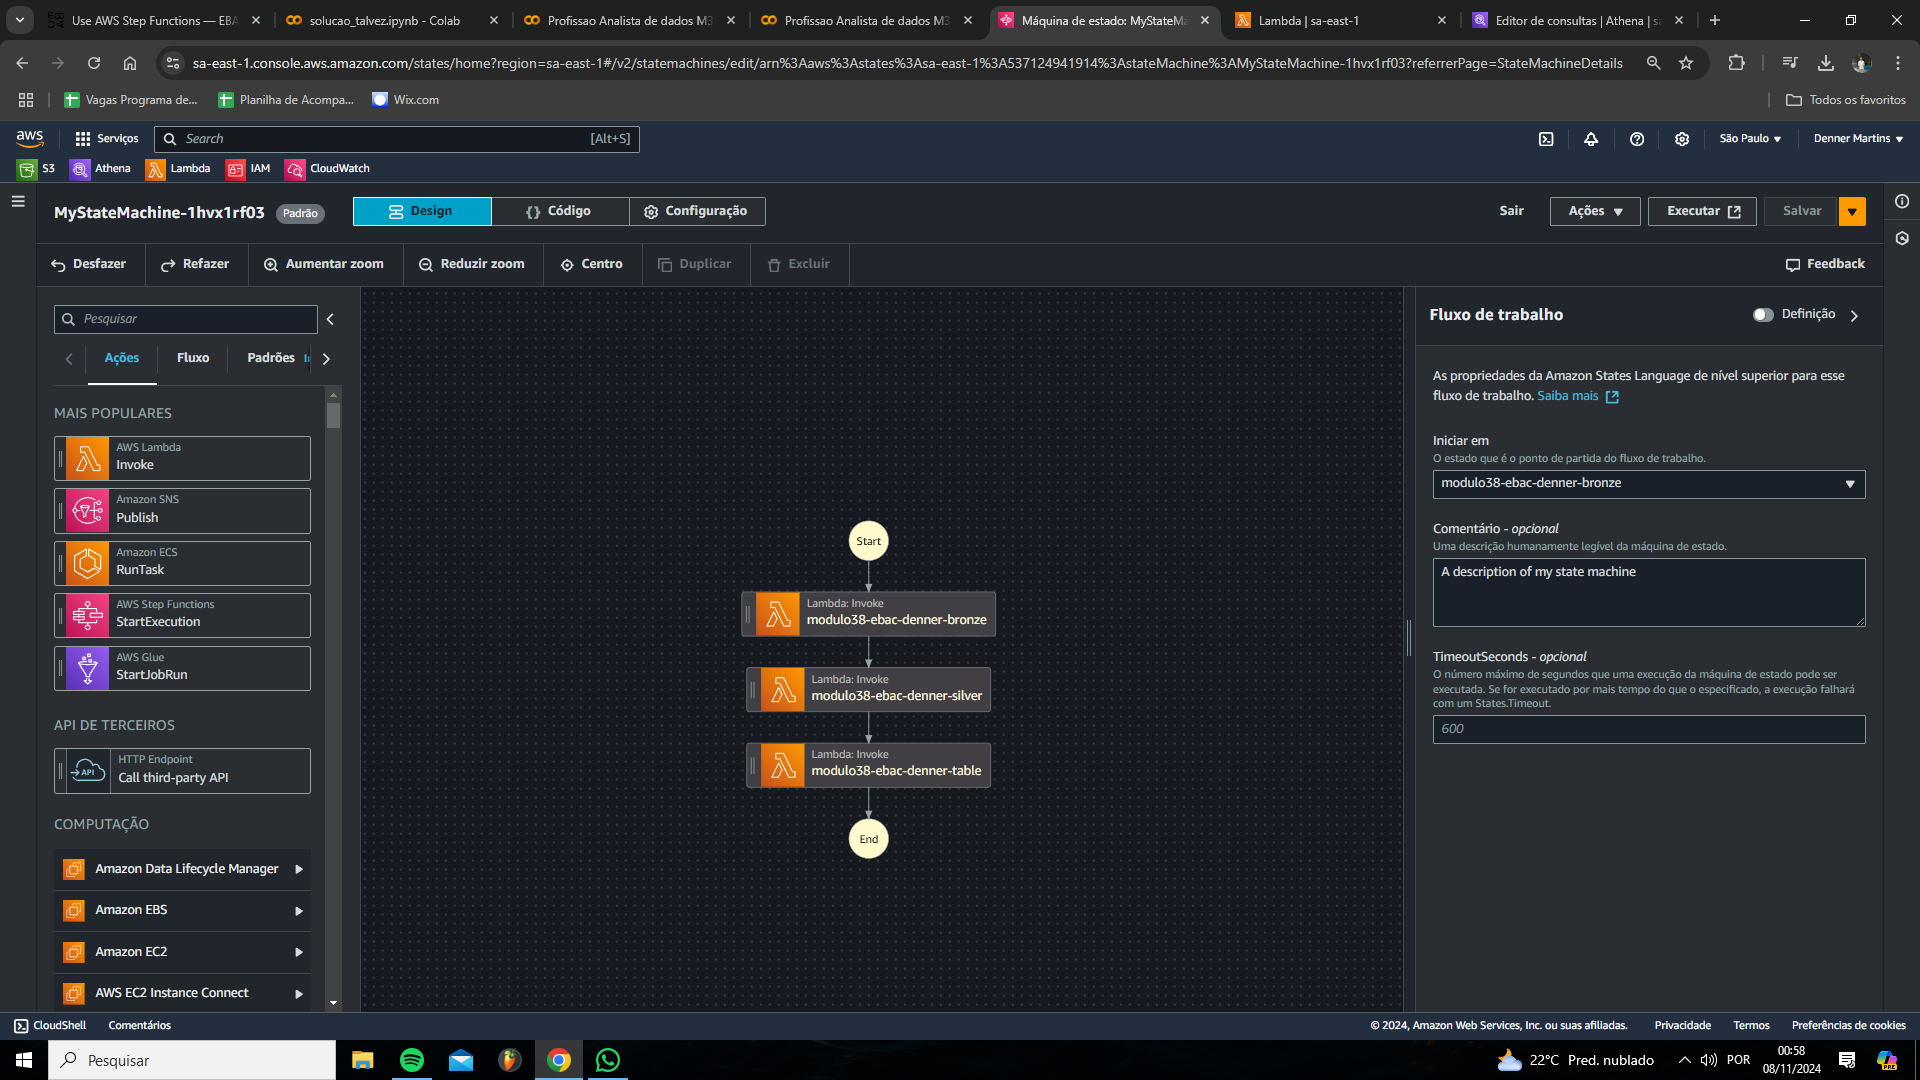

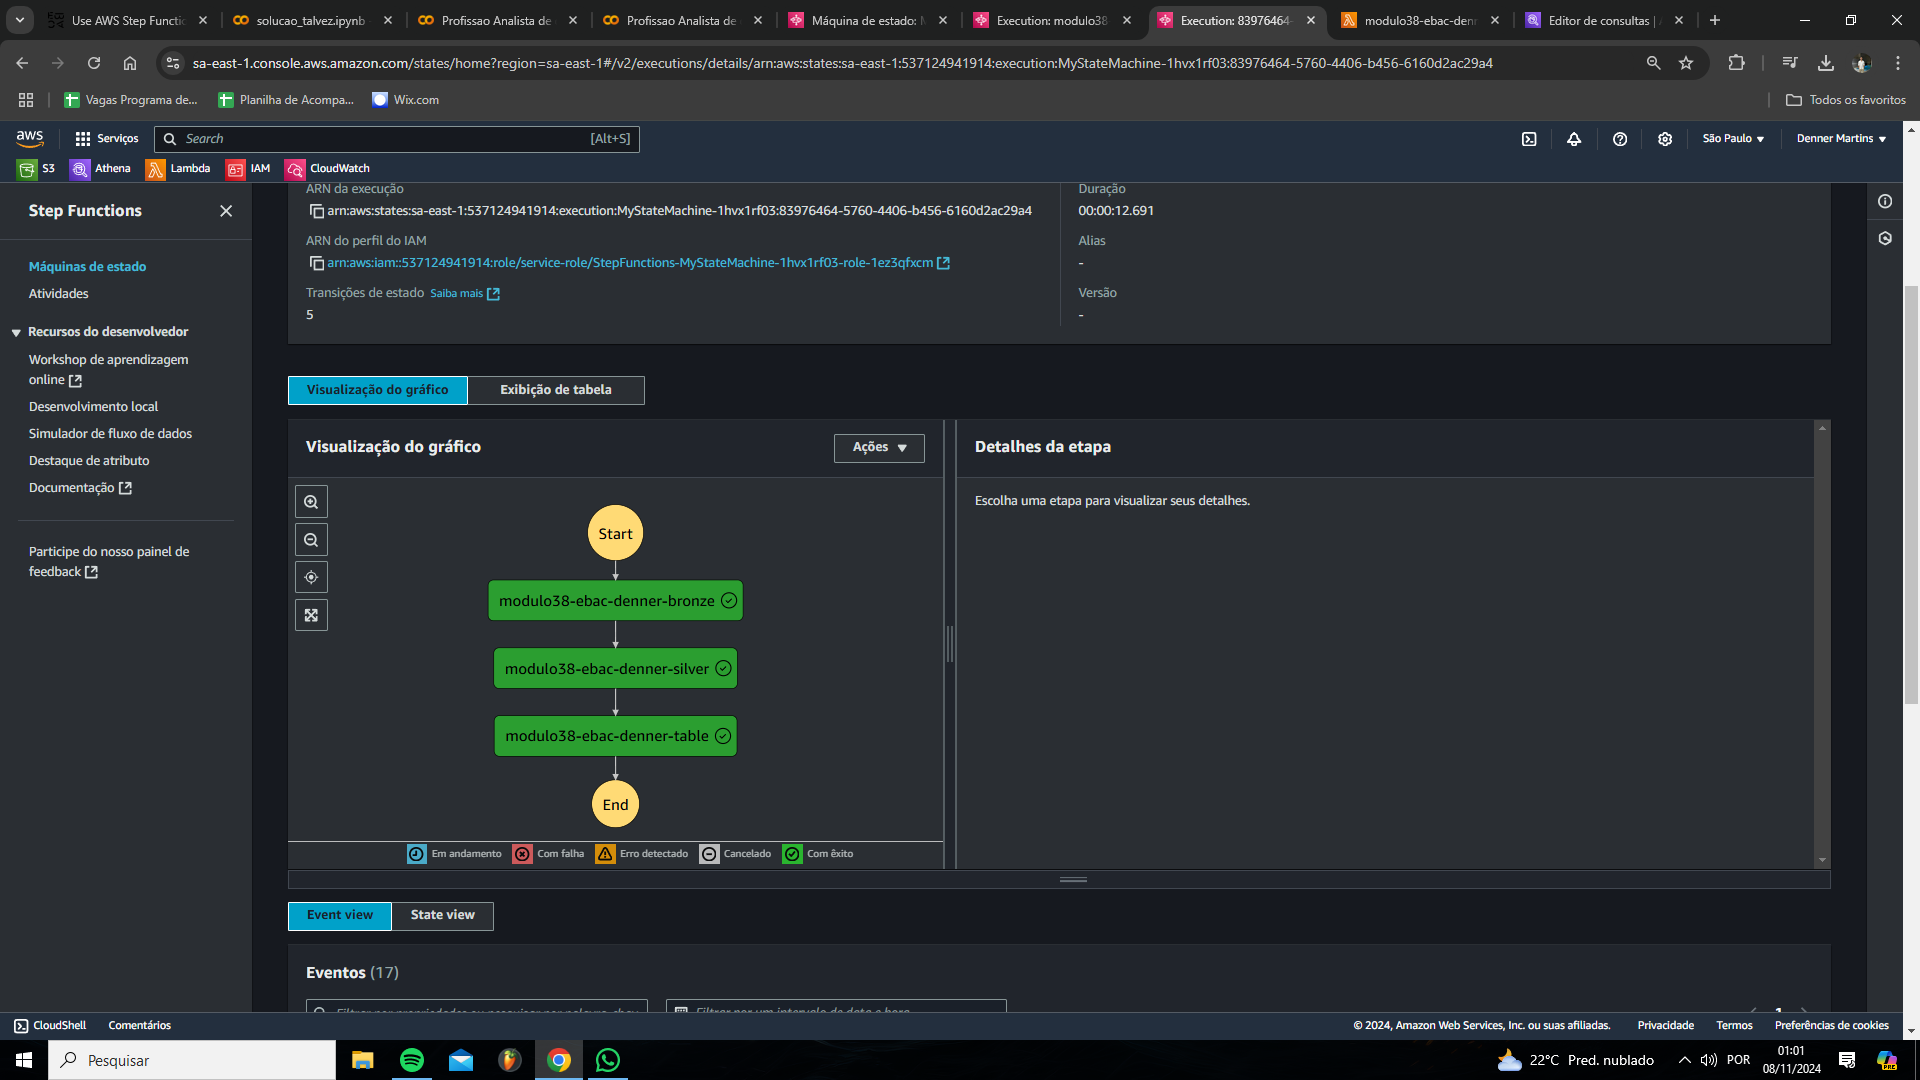

## 3\. AWS EventBridge

Replique as atividades do item 3.3 em sua conta.

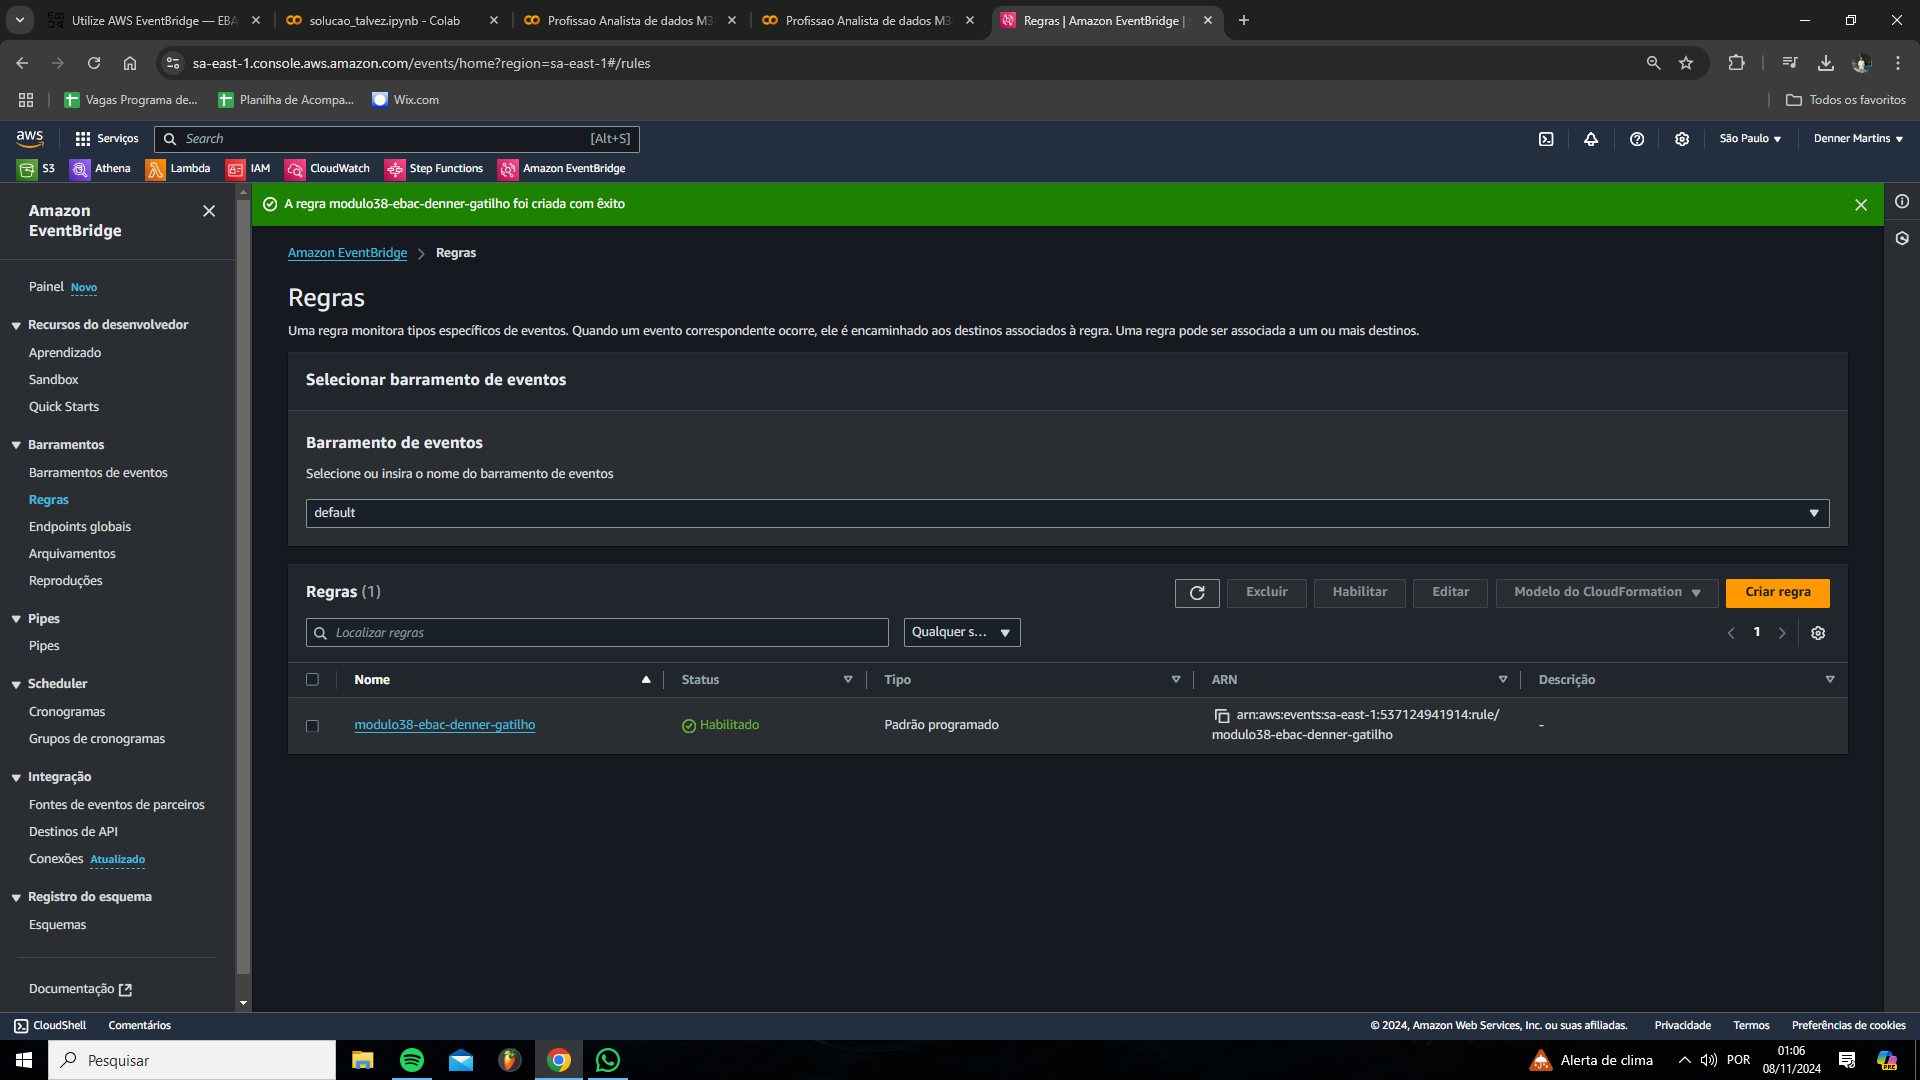